<a href="https://colab.research.google.com/github/acollin19/comp551_A1/blob/Angele/assignment1_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

## Process:
### Dataset 1: Hepatitis
* Task 1 : Preprocessing
    1. Preprocessing
    2. Distributions
* Task 2 : Implemenmting KNN and DT
    1. KNN
    2. DT
* Task 3 : Running Experiments
    1. Compare accuracy
    2. Different K values
    3. Max tree depth
    4. Different distance/costs
    5. Plots
    6. Key features in DT
    7. Key features in KNN

### Dataset 2: Messidor features
* Task 1 : Preprocessing
    1. Preprocessing
    2. Distributions
* Task 2 : Implemenmting KNN and DT
    1. KNN
    2. DT
* Task 3 : Running Experiments
    1. Compare accuracy
    2. Different K values
    3. Max tree depth
    4. Different distance/costs
    5. Plots
    6. Key features in DT
    7. Key features in KNN


In [24]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import scipy.spatial
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

In [25]:
# Arff file to csv from https://github.com/mfahadzafar/Convert-Arff-to-CSV/blob/master/arffToCsv.py
def getCSVFromArff(fileName):
    with open(fileName + '.arff', 'r') as fin:
        data = fin.read().splitlines(True)
        i = 0
    cols = []
    for line in data:
        line = line.lower()
        if ('@data' in line):
            i+= 1
            break
        else:
            #print line
            i+= 1
            if (line.startswith('@attribute')):
                if('{' in line):
                    cols.append(line[11:line.index('{')-1])
                else:
                    cols.append(line[11:line.index(' ', 11)])
    headers = ",".join(cols)
    with open(fileName + '.csv', 'w') as fout:
        fout.write(headers)
        fout.write('\n')
        fout.writelines(data[i:])

getCSVFromArff("messidor_features") #outputs a csv file into dir

In [26]:
# Loading/cleaning datasets
hepatitis = pd.read_csv("hepatitis.data", header=None)
hepatitis = hepatitis[(hepatitis != '?').all(axis=1)]
hepatitis = hepatitis.dropna().reset_index(drop=True)
hepatitis = hepatitis.apply(pd.to_numeric)

### Hepatitis Attribute Information:

1. Class: DIE, LIVE 
2. AGE: 10, 20, 30, 40, 50, 60, 70, 80 
3. SEX: male, female 
4. STEROID: no, yes 
5. ANTIVIRALS: no, yes 
6. FATIGUE: no, yes 
7. MALAISE: no, yes 
8. ANOREXIA: no, yes 
9. LIVER BIG: no, yes 
10. LIVER FIRM: no, yes 
11. SPLEEN PALPABLE: no, yes 
12. SPIDERS: no, yes 
13. ASCITES: no, yes 
14. VARICES: no, yes 
15. BILIRUBIN: 0.39, 0.80, 1.20, 2.00, 3.00, 4.00  
16. ALK PHOSPHATE: 33, 80, 120, 160, 200, 250 
17. SGOT: 13, 100, 200, 300, 400, 500, 
18. ALBUMIN: 2.1, 3.0, 3.8, 4.5, 5.0, 6.0 
19. PROTIME: 10, 20, 30, 40, 50, 60, 70, 80, 90 
20. HISTOLOGY: no, yes 



## Task 1.2 : Distributions

In [27]:
# Hepatitis Dataset
X = hepatitis.iloc[:, hepatitis.columns != 0].values # x -> features (1-19)
y = hepatitis.iloc[:, 0].values # y -> class label (0)

In [28]:
# Split Training and Testing without sklearn
split = 0.8
(N,D), C = X.shape, np.max(y)+1
inds = np.random.permutation(N)

n_train = math.floor(split * X.shape[0])
n_test = math.ceil(1-split * X.shape[0])
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]
# X_train, y_train = X[inds[:100]],y[inds[:100]]
# X_test, y_test = X[inds[:100]], y[inds[:100]]

print("Total Number of rows in train:",X_train.shape[0])
print("Total Number of rows in test:",X_test.shape[0])

Total Number of rows in train: 64
Total Number of rows in test: 16


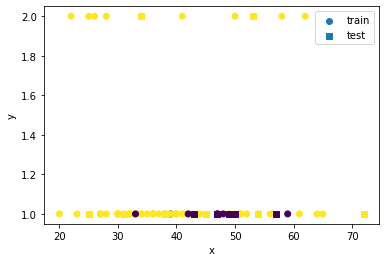

In [29]:
# Plotting

plt.scatter(X_train[:,0],X_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(X_test[:,0],X_test[:,1],c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('y')
plt.xlabel('x')
plt.show()

## Task 2 : K-Nearest Neighbour

Finding KNN models without using pre-existing libraries.

In [33]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN1:

    def __init__(self, K=1, dist_fn=euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
       
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
       
        y_prob /= self.K
        return y_prob, knns

    # Evaluating prediction accuracy on true and target labels
    def evaluate_acc(self, X_test, y_test, y_train,X_train ):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        acc_test = np.sum(y_test_pred==y_test)/len(y_test)
        acc_train = np.sum(y_train_pred==y_train)/len(y_train)

        return (acc_test,acc_train)

In [31]:
# Constructor class to initialize model parameters
class KNN:
    def __init__(self, k):
        self.k = k

    # Fit funcition takes input X and y
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    # Euclidean Distance function
    def distance(self, X1, X2):
        #distance = scipy.spatial.distance.euclidean(X1, X2)
        distance = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))

    
    # Predict function takes input X and outputs y
    def predict(self, X_test):
        output = []
        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(X_train)):
                dist = scipy.spatial.distance.euclidean(X_train[j] , X_test[i])
                d.append([dist, j])
            d.sort()
            d = d[0:self.k]
            for d, j in d:
                votes.append(y_train[j])
            ans = Counter(votes).most_common(1)[0][0]
            output.append(ans)
            
        return output
    
    # Evaluating prediction accuracy on true and target labels
    def evaluate_acc(self, X_test, y_test, y_train,X_train ):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        acc_test = np.sum(y_test_pred==y_test)/len(y_test)
        acc_train = np.sum(y_train_pred==y_train)/len(y_train)

        return (acc_test,acc_train)

In [34]:
classifier = KNN1(5)
classifier.fit(X_train, y_train)

# Evaluating prediction accuracy on training data
test,train = classifier.evaluate_acc(X_test,y_test,y_train, X_train)

print(f'Training Accuracy: {train}')
print(f'Testing Accuracy: {test}')

Training Accuracy: 0.0
Testing Accuracy: 0.0


In [ ]:
model = KNN1(5)
y_prob, knns = model.fit(X_train, y_train).predict(X_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(X_test[correct,0], X_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(X_test[incorrect,0], X_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(X_test.shape[0]):
    for k in range(model.K):
        hor = X_test[i,0], X_train[knns[i,k],0]
        ver = X_test[i,1], X_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
#plt.savefig('iris_KNN'+str(5)+'.png',dpi=300,bbox_inches='tight')
plt.show()

#Task 3 : Evaluation

## Task 3.2 : Choosing K in KNN

In [ ]:
# further split the training data into 50% training and 50% validation
x_train_tr, y_train_tr = x_train[:50], y_train[:50]
x_train_va, y_train_va = x_train[50:], y_train[50:]

model_choices=[]
valid_acc = []

n_valid = y_train_va.shape[0]

for k in range(1,11):
    knn = KNN(K=k) # create a KNN object (OOP)
    # y_train_va_prob,_ = knn.fit(x_train, y_train).predict(x_train_va) # wrong
    y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
    accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob,_ = knn.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

In [ ]:
classifier = KNN(5)
classifier.fit(X_train, y_train)

# Evaluating prediction accuracy on training data
test,train = classifier.evaluate_acc(X_test,y_test,y_train, X_train)

print(f'Training Accuracy: {train}')
print(f'Testing Accuracy: {test}')


## Task 2.2 : Decision Trees

# Dataset 2 : Messidor Features

## Task 1.1 Preprocessing

In [ ]:
features = pd.read_csv('messidor_features.csv')
features = features[(features != '?').all(axis=1)]
features = features.dropna().reset_index(drop=True)
features = features.apply(pd.to_numeric)
features.head()

### Features Attribute Information:

0. The binary result of quality assessment. 0 = bad quality 1 = sufficient quality.
1. The binary result of pre-screening, where 1 indicates severe retinal abnormality and 0 its lack.  
* (2-7). The results of MA detection. Each feature value stand for the number of MAs found at the confidence levels alpha = 0.5,...,1, respectively.     
* (8-15). contain the same information as 2-7) for exudates. However, as exudates are represented by a set of points rather than the number of pixels constructing the lesions, these features are normalized by dividing the number of lesions with the diameter of the ROI to compensate different image sizes.   
16. The euclidean distance of the center of the macula and the center of the optic disc to provide important information regarding the patientâ€™s condition. This feature is also normalized with the diameter of the ROI.   
17. The diameter of the optic disc.   
18. The binary result of the AM/FM-based classification.   
19. Class label. 1 = contains signs of DR (Accumulative label for the Messidor classes 1, 2, 3), 0 = no signs of DR. 

## Task 1.2 Distributions

In [ ]:
# Messidor features dataset
X = features.iloc[:,:-1].values # x -> features (0-18)
y = features.iloc[:,-1:].values # y -> class label (19)

# Split Training and Testing without sklearn
split = 0.8
n_train = math.floor(split * X.shape[0])
n_test = math.ceil(1-split * X.shape[0])
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]
print("Total Number of rows in train:",X_train.shape[0])
print("Total Number of rows in test:",X_test.shape[0])

In [ ]:
# Messidor Features Plotting


## Task 2 : K-Nearest Neighbour

In [ ]:
classifier = KNN(5)
classifier.fit(X_train, y_train)

# Evaluating prediction accuracy on training data
test,train = classifier.evaluate_acc(X_test,y_test,y_train, X_train)

print(f'Training Accuracy: {train}')
print(f'Testing Accuracy: {test}')


## Task 2.2 : Decision Trees